Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


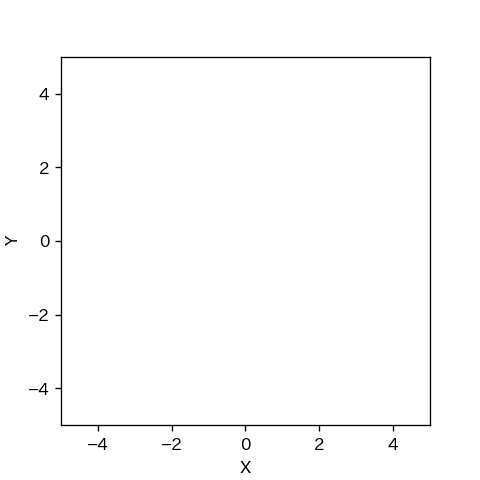

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


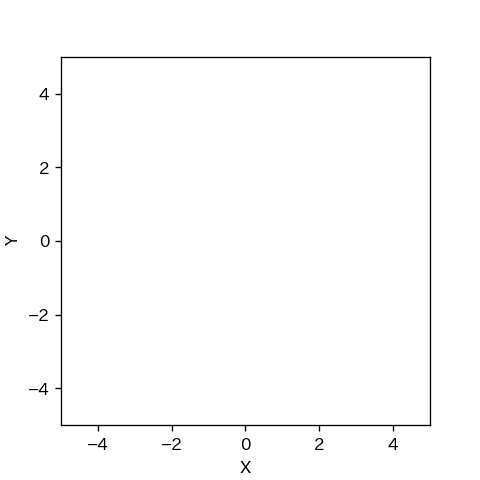

(array([-3.6188621 , -1.05153549,  0.68582671]),
 array([ 1.1285086 , -0.2923645 , -0.13035686]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.508621983977316]
[5.021649032210804]
0 真値: [-1.02449855  3.46157837  6.29212113] 推定値: [ 1.94076459  7.24776049 -1.28023803] 誤差: 4.809153825448798
[5.656168327290439]
[4.968696566140023, 4.096506812470926]
1 真値: [-0.3721836   2.81277871  3.86546552] 推定値: [-0.16741384  2.85785093  3.82186764] 誤差: 0.20967155017494832
1
[5.900446082020335]
2 真値: [ 2.55892052 -4.25723707  5.43001987] 推定値: [ 2.27305175 -3.95568213  5.15952016] 誤差: 0.41551935362386533
2
3 真値: [-2.04566334 -4.68423608  5.279487  ] 推定値: [-1.65548125 -3.97339094  5.46208115] 誤差: 0.8108901719193676
3
[1.8308501474767922]
4 真値: [ 1.70905317 -5.29331995  6.09813418] 推定値: [ 3.08548016 -1.67328525  2.710013  ] 誤差: 3.8728803781851227
5 真値: [-5.6811726  -2.30995561  6.33277647] 推定値: [ 1.65827475 -2.30981014  7.61841452] 誤差: 7.339447350354305
[1.7390817860855168, 5.061613913591268]
[1.6313107943063017, 5.328976364981348]
[5.366757475539905, 3.4366892674486125]
6 真値: [ 0.46569625 -1.38317116  5.85389881] 推定値: [ 0.36585846 -1.5227248  

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[6.9376313229039654]
20 真値: [-4.20947633  1.16586374  3.9513671 ] 推定値: [-4.77938452  1.41526736  2.96062729] 誤差: 0.6220912399626115
13
[5.557789063694056]
21 真値: [0.88848487 2.15259958 2.99244411] 推定値: [0.46323317 2.41936747 3.08160261] 誤差: 0.5020001204986616
14
[3.1409391233084807]
[4.547329738660427]
22 真値: [3.95231893 2.11334665 4.94830822] 推定値: [ 1.63716976  2.25862356 -0.83346206] 誤差: 2.3197027951732947
23 真値: [-1.44799085  3.76043187  4.77998645] 推定値: [-1.23695473  4.15699683  4.82664149] 誤差: 0.4492215619126531
15
[2.171562369372625]
24 真値: [ 3.06900243 -0.04763223  6.19132169] 推定値: [ 2.59563357 -0.17266099  6.34039781] 誤差: 0.48960215628609594
16
[7.514690930151909]
25 真値: [ 2.01851877 -2.58780972  4.71113257] 推定値: [ 2.15638609 -2.5818877   4.37655707] 誤差: 0.13799445793602158
17
[2.2820761416048474]
26 真値: [0.92333228 2.05455802 5.50064386] 推定値: [1.08723151 2.11806617 5.53203721] 誤差: 0.17577327291736386
18
[5.46235976827251]
27 真値: [-5.2201514   2.75353679  5.26221006] 推定値: [-5.0